# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [66]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import hstack

from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import roc_auc_score

import numpy as np
import seaborn as sns

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [67]:
#make sure you are loading atleast 50k datapoints
#you can work with features of preprocessed_data.csv for the assignment.
# If you want to add more features, you can add. (This is purely optional, not mandatory)

import pandas as pd
data = pd.read_csv('preprocessed_data.csv', nrows=100000)

In [68]:
data.shape

(100000, 9)

In [69]:
data.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [70]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05


In [71]:
X.shape

(100000, 8)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [72]:
# write your code in following steps for task 1
# 1. Split your data.
# 2. Perform Bag of Words Vectorization of text data.
# 3. Perform tfidf vectorization of text data.
# 4. perform one-hot encoding of categorical features.
# 5. perform normalization of numerical features
# 6. For set 1 stack up all the features using hstack()
# 7. For set 2 stack up all the features using hstack()
# 8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values, using a 2D line plot.
# 9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
# 10. Plot confusion matrix based on the best threshold value
# 11. Either for the model in set 1 or in set 2, print the top 20 features(you have to print the names, not the indexes) associated with the positive and negative classes each.
# 12. Summarize your observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
# 13. You can use Prettytable or any other tabular format for comparison.


# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
    

In [73]:
# Split the dataset 
# 1) If you want to apply simple cross-validation, split the dataset into 3 parts (ie., train, CV and test sets)
# 2) If you want to apply K-fold CV (or) GridSearch Cross Validation (or) Randomized Search Cross Validation, just split the dataset into 2 parts (ie., train and test sets)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [74]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print('='*120)

(80000, 8) (80000,)
(20000, 8) (20000,)


<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [75]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay'
vectorizer_essay_bow = CountVectorizer(min_df=10)
# tried to experiment with the max_features and n_grams
# vectorizer_essay_bow = CountVectorizer(min_df=10, ngram_range=(1, 4) max_features=10000)
# vectorizer_essay_bow = CountVectorizer(min_df=10, ngram_range=(1, 5) max_features=5000)
vectorizer_essay_bow.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer_essay_bow.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer_essay_bow.transform(X_test['essay'].values)

print('After vectorizations')
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)
print('='*120)

After vectorizations
(80000, 14691) (80000,)
(20000, 14691) (20000,)


In [76]:
"""
# Apply Bag of Words (BOW) vectorization on 'Project_title' (Optional)
vectorizer_title = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_title.fit(X_train['project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer_title.transform(X_train['project_title'].values)
X_test_title_bow = vectorizer_title.transform(X_test['project_title'].values)

print('After vectorizations')
print(X_train_title_bow.shape, y_train.shape)
print(X_test_title_bow.shape, y_test.shape)
print('='*120)"""

"\n# Apply Bag of Words (BOW) vectorization on 'Project_title' (Optional)\nvectorizer_title = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)\nvectorizer_title.fit(X_train['project_title'].values) # fit has to happen only on train data\n\n# we use the fitted CountVectorizer to convert the text to vector\nX_train_title_bow = vectorizer_title.transform(X_train['project_title'].values)\nX_test_title_bow = vectorizer_title.transform(X_test['project_title'].values)\n\nprint('After vectorizations')\nprint(X_train_title_bow.shape, y_train.shape)\nprint(X_test_title_bow.shape, y_test.shape)\nprint('='*120)"

In [77]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
# Apply TF-IDF vectorization on 'Preprocessed_Title' (Optional)
vectorizer_essay_tfidf = TfidfVectorizer(min_df=10)
vectorizer_essay_tfidf.fit(X_train['essay'])

X_train_essay_tfidf = vectorizer_essay_tfidf.transform(X_train['essay'])
X_test_essay_tfidf = vectorizer_essay_tfidf.transform(X_test['essay'])

print('After TF-IDF vectorizations')
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print('='*120)

After TF-IDF vectorizations
(80000, 14691) (80000,)
(20000, 14691) (20000,)


# <h2>1.4.1. Make Data Model Ready: Encoding categorical features</h2>

In [78]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() (or) CountVectorizer(binary=True)
# Apply Normalization on the numerical features using Normalizer().

vectorizer_clean_cat = CountVectorizer()
vectorizer_clean_cat.fit(X_train['clean_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_categories_ohe = vectorizer_clean_cat.transform(X_train['clean_categories'].values)
X_test_clean_categories_ohe = vectorizer_clean_cat.transform(X_test['clean_categories'].values)


print('After vectorizations')
print(X_train_clean_categories_ohe.shape, y_train.shape)
print(X_test_clean_categories_ohe.shape, y_test.shape)
print(vectorizer_clean_cat.get_feature_names())
print('='*120)

After vectorizations
(80000, 9) (80000,)
(20000, 9) (20000,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']


In [79]:
vectorizer_clean_subcat = CountVectorizer()
vectorizer_clean_subcat.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_clean_subcategories_ohe = vectorizer_clean_subcat.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories_ohe = vectorizer_clean_subcat.transform(X_test['clean_subcategories'].values)


print('After vectorizations')
print(X_train_clean_subcategories_ohe.shape, y_train.shape)
print(X_test_clean_subcategories_ohe.shape, y_test.shape)
print(vectorizer_clean_subcat.get_feature_names())
print('='*120)

After vectorizations
(80000, 30) (80000,)
(20000, 30) (20000,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']


In [80]:
vectorizer_grade = CountVectorizer()
vectorizer_grade.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer_grade.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer_grade.transform(X_test['project_grade_category'].values)

print('After vectorizations')
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)
print(vectorizer_grade.get_feature_names())
print('='*120)

After vectorizations
(80000, 4) (80000,)
(20000, 4) (20000,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']


In [81]:
vectorizer_state = CountVectorizer()
vectorizer_state.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer_state.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer_state.transform(X_test['school_state'].values)

print('After vectorizations')
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer_state.get_feature_names())
print('='*120)

After vectorizations
(80000, 51) (80000,)
(20000, 51) (20000,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


In [82]:
vectorizer_teacher = CountVectorizer()
vectorizer_teacher.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer_teacher.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_teacher.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)
print(vectorizer_teacher.get_feature_names())
print("="*120)

After vectorizations
(80000, 5) (80000,)
(20000, 5) (20000,)
['dr', 'mr', 'mrs', 'ms', 'teacher']


<h2>1.4.2. Make Data Model Ready: Encoding numerical features</h2>

In [83]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

print('After normalisation')
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_train.shape)
print('='*120)

After normalisation
(80000, 1) (80000,)
(20000, 1) (80000,)


In [84]:
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_previously_posted_projects_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_previously_posted_projects_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print('After normalisation')
print(X_train_previously_posted_projects_norm.shape, y_train.shape)
print(X_test_previously_posted_projects_norm.shape, y_train.shape)
print('='*120)

After normalisation
(80000, 1) (80000,)
(20000, 1) (80000,)


In [85]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# from scipy.sparse import hstack
X_tr_set1 = hstack((X_train_essay_bow,
               X_train_clean_categories_ohe,
               X_train_clean_subcategories_ohe, 
               X_train_grade_ohe, 
               X_train_state_ohe, 
               X_train_teacher_ohe, 
               X_train_price_norm, 
               X_train_previously_posted_projects_norm)).tocsr()

X_te_set1 = hstack((X_test_essay_bow,
               X_test_clean_categories_ohe,
               X_test_clean_subcategories_ohe, 
               X_test_grade_ohe, 
               X_test_state_ohe, 
               X_test_teacher_ohe, 
               X_test_price_norm, 
               X_test_previously_posted_projects_norm)).tocsr()

print('Final Data Matrix')
print(X_tr_set1.shape, y_train.shape)
print(X_te_set1.shape, y_test.shape)
print('='*120)

Final Data Matrix
(80000, 14792) (80000,)
(20000, 14792) (20000,)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

## Set 1

In [86]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# from sklearn.model_selection import GridSearchCV
# from scipy.stats import randint as sp_randint
# from sklearn.model_selection import RandomizedSearchCV


parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 
                       1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}

mnb_bow = MultinomialNB(class_prior=[0.5, 0.5], fit_prior=False)
clf = GridSearchCV(mnb_bow, parameters, cv=10, scoring='roc_auc', verbose=1, return_train_score=True)
clf.fit(X_tr_set1, y_train)

train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

cv_auc = clf.cv_results_['mean_test_score']
cv_auc_std = clf.cv_results_['std_test_score']

best_alpha_bow = clf.best_params_['alpha']
best_score_bow = clf.best_score_
print('Best Alpha: ', best_alpha_bow, "Best Score: ", best_score_bow) #clf.best_estimator_.alpha

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Alpha:  0.5 Best Score:  0.7046748548074189


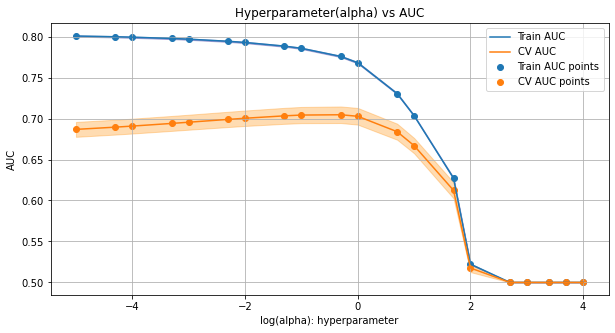

In [87]:
alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]

log_alphas =[]
for a in alphas:
    b = np.log10(a)
    log_alphas.append(b)

plt.figure(figsize=(10,5))
plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')
plt.scatter(log_alphas, train_auc, label='Train AUC points')
plt.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter(alpha) vs AUC")
plt.grid()
plt.show()

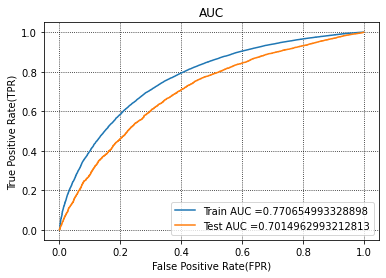

In [88]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Note: If you have split the datase into 3 parts (ie., train, cv and test sets) in the beginning, then the training data for this final model would be (train set + cv set)
# Make class label and probability predictions on the train and test data.

'''
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
mnb_bow_test_model = MultinomialNB(alpha=best_alpha_bow, class_prior=[0.5, 0.5], fit_prior=False)
mnb_bow_test_model.fit(X_tr_set1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(mnb_bow_test_model, X_tr_set1)    
y_test_pred = batch_predict(mnb_bow_test_model, X_te_set1)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel('Alpha: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.grid()
plt.show()
'''



#https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
mnb_bow_test_model = MultinomialNB(alpha = best_alpha_bow, class_prior=[0.5, 0.5], fit_prior=False)
mnb_bow_test_model.fit(X_tr_set1, y_train)

y_train_pred = mnb_bow_test_model.predict_proba(X_tr_set1)[:,1]
y_test_pred = mnb_bow_test_model.predict_proba(X_te_set1)[:,1]


# Plot the ROC-AUC curves using the probability predictions made on train and test data.
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

ax = plt.subplot()
auc_train_set1 = auc(train_fpr, train_tpr)
auc_test_set1 = auc(test_fpr, test_tpr)

ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

In [89]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.4974692978872884 for threshold 0.54
Train confusion matrix
[[ 8721  3425]
 [20842 47012]]


[Text(0.5, 15.0, 'Predected'), Text(33.0, 0.5, 'Actual')]

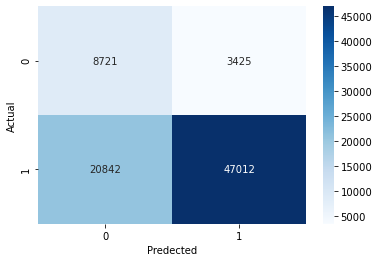

In [90]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

print('='*120)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
print(cm_train)
p = sns.heatmap(cm_train, annot=True, fmt="d", cmap='Blues')
p.set(xlabel='Predected', ylabel='Actual')

Test confusion matrix
[[ 1935  1102]
 [ 5557 11406]]


[Text(0.5, 15.0, 'Predected'), Text(33.0, 0.5, 'Actual')]

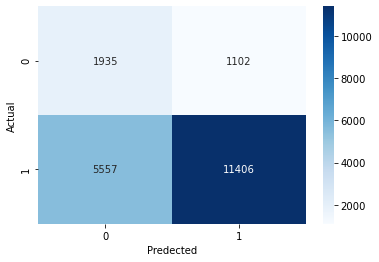

In [91]:
print("Test confusion matrix")
#print(confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
cm_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
print(cm_test)
p = sns.heatmap(cm_test, annot=True, fmt="d", cmap='Blues')
p.set(xlabel='Predected', ylabel='Actual')

## Set 2

In [92]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
# from scipy.sparse import hstack
# X_train_essay_tfidf
X_tr_set2 = hstack((X_train_essay_tfidf,
               X_train_clean_categories_ohe,
               X_train_clean_subcategories_ohe, 
               X_train_grade_ohe, 
               X_train_state_ohe, 
               X_train_teacher_ohe, 
               X_train_price_norm, 
               X_train_previously_posted_projects_norm)).tocsr()

X_te_set2 = hstack((X_test_essay_tfidf,
               X_test_clean_categories_ohe,
               X_test_clean_subcategories_ohe, 
               X_test_grade_ohe, 
               X_test_state_ohe, 
               X_test_teacher_ohe, 
               X_test_price_norm, 
               X_test_previously_posted_projects_norm)).tocsr()

print('Final Data Matrix')
print(X_tr_set2.shape, y_train.shape)
print(X_te_set2.shape, y_test.shape)
print('='*120)

Final Data Matrix
(80000, 14792) (80000,)
(20000, 14792) (20000,)


In [93]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# from sklearn.model_selection import GridSearchCV
# from scipy.stats import randint as sp_randint
# from sklearn.model_selection import RandomizedSearchCV


parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 
                       1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]}

mnb_tfidf = MultinomialNB(class_prior=[0.5, 0.5], fit_prior=False)
clf = GridSearchCV(mnb_tfidf, parameters, cv=10, scoring='roc_auc', verbose=1, return_train_score=True)
clf.fit(X_tr_set2, y_train)

train_auc = clf.cv_results_['mean_train_score']
train_auc_std = clf.cv_results_['std_train_score']

test_auc = clf.cv_results_['mean_test_score']
test_auc_std = clf.cv_results_['std_test_score']

best_alpha_tfidf = clf.best_params_['alpha']
best_score_tfidf = clf.best_score_
print('Best Alpha: ', best_alpha_tfidf, "Best Score: ", best_score_tfidf) #clf.best_estimator_.alpha

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Alpha:  0.05 Best Score:  0.679661351322252


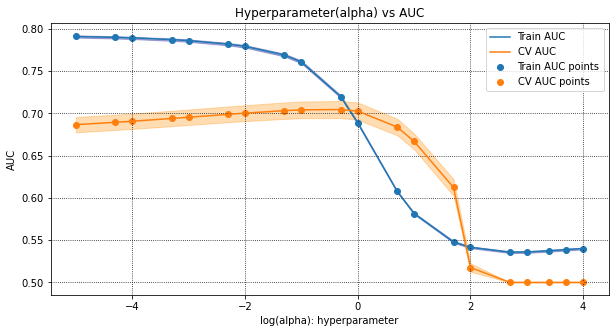

In [94]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

alphas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 2500, 5000, 10000]

log_alphas =[]
for a in alphas:
    b = np.log10(a)
    log_alphas.append(b)

plt.figure(figsize=(10,5))
plt.plot(log_alphas, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.3,color='darkblue')
plt.plot(log_alphas, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(log_alphas,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.3,color='darkorange')

ax = plt.subplot()
ax.scatter(log_alphas, train_auc, label='Train AUC points')
ax.scatter(log_alphas, cv_auc, label='CV AUC points')
plt.legend()
plt.xlabel("log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("Hyperparameter(alpha) vs AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

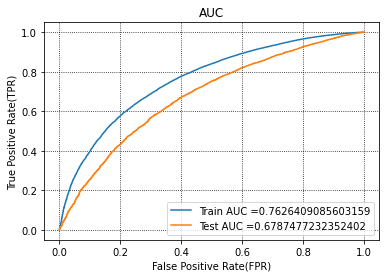

In [95]:
'''# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
mnb_bow_test_model = MultinomialNB(alpha=best_alpha_tfidf, class_prior=[0.5, 0.5], fit_prior=False)
mnb_bow_test_model.fit(X_tr_set2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(mnb_bow_test_model, X_tr_set2)    
y_test_pred = batch_predict(mnb_bow_test_model, X_te_set2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()'''

#https://scikitlearn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
mnb_tfidf_test_model = MultinomialNB(alpha = best_alpha_tfidf, class_prior=[0.5, 0.5], fit_prior=False)
mnb_tfidf_test_model.fit(X_tr_set2, y_train)

y_train_pred = mnb_tfidf_test_model.predict_proba(X_tr_set2)[:,1]
y_test_pred = mnb_tfidf_test_model.predict_proba(X_te_set2)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC-AUC curves using the probability predictions made on train and test data.
ax = plt.subplot()
auc_train_set2 = auc(train_fpr, train_tpr)
auc_test_set2 = auc(test_fpr, test_tpr)

ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))

plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

the maximum value of tpr*(1-fpr) 0.48235147566060543 for threshold 0.501
Train confusion matrix
[[ 8402  3744]
 [20540 47314]]


[Text(0.5, 15.0, 'Predected'), Text(33.0, 0.5, 'Actual')]

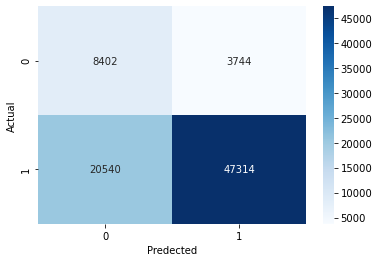

In [96]:
print('='*120)
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
cm_train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
print(cm_train)
p = sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
p.set(xlabel='Predected', ylabel='Actual')

Test confusion matrix
[[ 1795  1242]
 [ 5470 11493]]


[Text(0.5, 15.0, 'Predected'), Text(33.0, 0.5, 'Actual')]

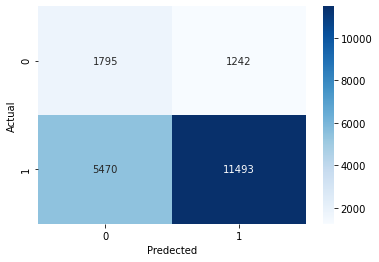

In [97]:
print("Test confusion matrix")
cm_test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))
print(cm_test)
p = sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
p.set(xlabel='Predected', ylabel='Actual')

In [98]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)


all_features_names_bow =  []

all_features_names_bow.extend(vectorizer_essay_bow.get_feature_names())

all_features_names_bow.extend(vectorizer_clean_cat.get_feature_names())

all_features_names_bow.extend(vectorizer_clean_subcat.get_feature_names())

all_features_names_bow.extend(vectorizer_grade.get_feature_names())

all_features_names_bow.extend(vectorizer_state.get_feature_names())

all_features_names_bow.extend(vectorizer_teacher.get_feature_names())

all_features_names_bow.append('price')

all_features_names_bow.append('previously_posted_projects')

total_feature_names_bow = len(all_features_names_bow)
print(total_feature_names_bow)

14792


In [99]:
nb_bow = MultinomialNB(alpha=best_alpha_bow, class_prior=[0.5,0.5], fit_prior=False)
nb_bow.fit(X_tr_set1, y_train)

MultinomialNB(alpha=0.5, class_prior=[0.5, 0.5], fit_prior=False)

In [100]:
bow_features_probs_neg = {}
for ele in range(total_feature_names_bow):
    bow_features_probs_neg[ele] = nb_bow.feature_log_prob_[0, ele]

In [101]:
final_bow_features_neg = pd.DataFrame({'feature_prob': list(bow_features_probs_neg.values()),
                                       'feature_names': list(all_features_names_bow)})

In [102]:
# final_bow_features_neg

In [103]:
bow_neg_ascending_order = final_bow_features_neg.sort_values(by=['feature_prob'], ascending=False)

In [104]:
print('Top 10 Negative features - Bag of words')
bow_neg_ascending_order.head(10)

Top 10 Negative features - Bag of words


,feature_prob,feature_names
12643,-3.065752,students
11471,-4.157452,school
7564,-4.488059,learning
8580,-4.531618,my
2470,-4.638816,classroom
8808,-4.824303,not
7560,-4.840071,learn
13191,-4.859256,they
6216,-4.875371,help
13152,-4.887148,the


In [105]:
bow_features_probs_pos = {}
for ele in range(total_feature_names_bow):
    bow_features_probs_pos[ele] = nb_bow.feature_log_prob_[1, ele]

final_bow_features_pos = pd.DataFrame({'feature_prob': list(bow_features_probs_pos.values()),
                                       'feature_names': list(all_features_names_bow)})

bow_pos_ascending_order = final_bow_features_pos.sort_values(by=['feature_prob'], ascending=False)
print('Top 10 Positive features - Bag of words')
bow_pos_ascending_order.head(10)

Top 10 Positive features - Bag of words


,feature_prob,feature_names
12643,-3.054700,students
11471,-4.204875,school
8580,-4.510868,my
7564,-4.566358,learning
2470,-4.589837,classroom
13152,-4.814427,the
13191,-4.851104,they
8808,-4.859002,not
7560,-4.903164,learn
6216,-4.932881,help


In [106]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)

## FOR SET 2
all_features_names_tfidf =  []

all_features_names_tfidf.extend(vectorizer_essay_tfidf.get_feature_names())

all_features_names_tfidf.extend(vectorizer_clean_cat.get_feature_names())

all_features_names_tfidf.extend(vectorizer_clean_subcat.get_feature_names())

all_features_names_tfidf.extend(vectorizer_grade.get_feature_names())

all_features_names_tfidf.extend(vectorizer_state.get_feature_names())

all_features_names_tfidf.extend(vectorizer_teacher.get_feature_names())

all_features_names_tfidf.append('price')

all_features_names_tfidf.append('previously_posted_projects')

total_feature_names_tfidf = len(all_features_names_tfidf)
print(total_feature_names_tfidf)

14792


In [107]:
nb_tfidf = MultinomialNB(alpha=best_alpha_tfidf, class_prior=[0.5,0.5], fit_prior=False)
nb_tfidf.fit(X_tr_set2, y_train)

MultinomialNB(alpha=0.05, class_prior=[0.5, 0.5], fit_prior=False)

In [108]:
tfidf_features_probs_neg = {}
for ele in range(total_feature_names_tfidf):
    tfidf_features_probs_neg[ele] = nb_tfidf.feature_log_prob_[0, ele]

final_tfidf_features_neg = pd.DataFrame({'feature_prob': list(tfidf_features_probs_neg.values()),
                                       'feature_names': list(all_features_names_tfidf)})

tfidf_neg_ascending_order = final_tfidf_features_neg.sort_values(by=['feature_prob'], ascending=False)

print('Top 10 Negative features - TF-IDF')
tfidf_neg_ascending_order.head(10)

Top 10 Negative features - TF-IDF


,feature_prob,feature_names
14790,-2.800423,price
14791,-3.197197,previously_posted_projects
14787,-3.491428,mrs
14695,-3.652419,literacy_language
14733,-3.708386,grades_prek_2
14696,-3.731304,math_science
14788,-3.800699,ms
14730,-3.908125,grades_3_5
14717,-4.137077,literacy
14719,-4.153188,mathematics


In [109]:
tfidf_features_probs_pos = {}
for ele in range(total_feature_names_tfidf):
    tfidf_features_probs_pos[ele] = nb_tfidf.feature_log_prob_[1, ele]

final_tfidf_features_pos = pd.DataFrame({'feature_prob': list(tfidf_features_probs_pos.values()),
                                       'feature_names': list(all_features_names_tfidf)})

tfidf_pos_ascending_order = final_tfidf_features_pos.sort_values(by=['feature_prob'], ascending=False)

print('Top 10 Positive features - TF-IDF')
tfidf_pos_ascending_order.head(10)

Top 10 Positive features - TF-IDF


,feature_prob,feature_names
14790,-2.811131,price
14791,-3.129875,previously_posted_projects
14787,-3.442639,mrs
14695,-3.526149,literacy_language
14733,-3.719881,grades_prek_2
14696,-3.787146,math_science
14788,-3.854442,ms
14730,-3.876863,grades_3_5
14717,-3.958251,literacy
14719,-4.168517,mathematics


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [110]:
# Summarize your assignment work here in a few points, and also compare the final models (from set 1 and set 2), in terms of optimal hyperparameter value 'alpha', training AUC and test AUC scores.
# You can either use a pretty table or any other tabular structure.
# Reference Link for Pretty table:  https://pypi.org/project/prettytable/
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter: Alpha", "Train AUC", "Test AUC"]

x.add_row(["BOW", "Multinomial Naive Bayes", best_alpha_bow, round(auc_train_set1, 2), round(auc_test_set1, 2)])
x.add_row(["TF-IDF", "Multinomial Naive Bayes", best_alpha_tfidf, round(auc_train_set2, 2), round(auc_test_set2, 2)])

print(x)

+------------+-------------------------+-----------------------+-----------+----------+
| Vectorizer |          Model          | Hyperparameter: Alpha | Train AUC | Test AUC |
+------------+-------------------------+-----------------------+-----------+----------+
|    BOW     | Multinomial Naive Bayes |          0.5          |    0.77   |   0.7    |
|   TF-IDF   | Multinomial Naive Bayes |          0.05         |    0.76   |   0.68   |
+------------+-------------------------+-----------------------+-----------+----------+
